## Imports

In [1]:
import ROOT
import numpy as np

Welcome to JupyROOT 6.22/02


## Define Functions

In [2]:
def set_title(plot, title, x_label, y_label, z_label):
    plot.SetTitle(title)
    ROOT.gPad.Update()
    
    plot.GetXaxis().SetTitle(x_label)
    plot.GetXaxis().SetLabelSize(0.025)
    plot.GetXaxis().SetTitleSize(0.025)
    plot.GetXaxis().SetTitleOffset(2)
    
    plot.GetYaxis().SetTitle(y_label)
    plot.GetYaxis().SetLabelSize(0.025)
    plot.GetYaxis().SetTitleSize(0.025)
    plot.GetYaxis().SetTitleOffset(2)
    
    plot.GetZaxis().SetTitle(z_label)
    plot.GetZaxis().SetLabelSize(0.025)
    plot.GetZaxis().SetTitleSize(0.025)
    plot.GetZaxis().SetTitleOffset(1.8)

## Simulation Paramaters

In [3]:
treshold_start = 0
treshold_end = 50
treshold_step_count = 30

real_signal_mu = 70
real_signal_sigma = 20
model_signal_mu_start = 20
model_signal_mu_end = 120
model_signal_mu_step_count = 30
model_signal_sigma_start = 5
model_signal_sigma_end = 35
model_signal_sigma_step_count = 30

real_noise_mu = 0
real_noise_sigma = 5
model_noise_sigma_start = 2
model_noise_sigma_end = 10
model_noise_sigma_step_count = 30

real_event_count = 1000
real_event_ratio = 0.4
model_event_ratio_start = 0.1
model_event_ratio_end = 0.9
model_event_ratio_step_count = 30

## Preparations

In [4]:
canvas = ROOT.TCanvas("canvas 1", "canvas 1", 1000, 800)
ROOT.gStyle.SetTitleFontSize(0.035)
ROOT.gStyle.SetTitleOffset(1)

prng = ROOT.TRandom3(123)

In [5]:
treshold_values = np.linspace(treshold_start, treshold_end, treshold_step_count)
model_signal_mus = np.linspace(model_signal_mu_start, model_signal_mu_end, model_signal_mu_step_count)
model_signal_sigmas = np.linspace(model_signal_sigma_start, model_signal_sigma_end, model_signal_sigma_step_count)
model_noise_sigmas = np.linspace(model_noise_sigma_start, model_noise_sigma_end, model_noise_sigma_step_count)
model_event_ratios = np.linspace(model_event_ratio_start, model_event_ratio_end, model_event_ratio_step_count)

real_signal_count = int(round(real_event_count * real_event_ratio))
real_noise_count = real_event_count - real_signal_count

## Signal μ unknown

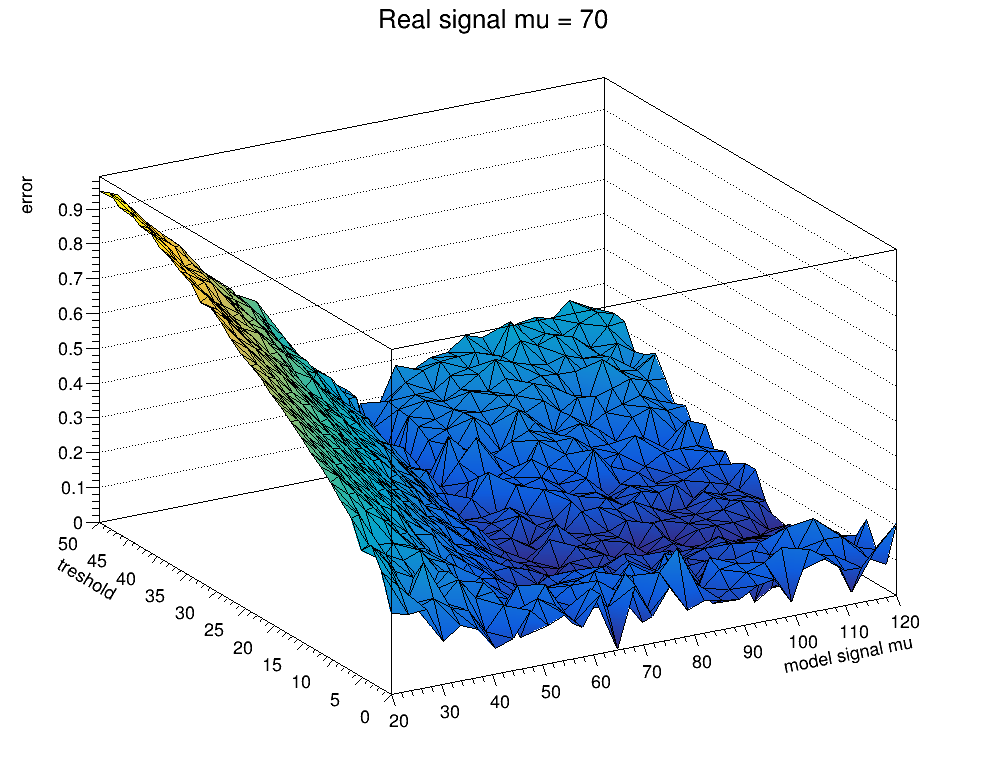

In [6]:
# Assume everything is known exactly except for signal_mu
signal_mu_uncertain_plot = ROOT.TGraph2D()
point_index = 0

real_noise = ROOT.TF1("ElecNoiseBg", "TMath::Gaus(x, %f, %f)" % (real_noise_mu, real_noise_sigma), -100, 500)
real_noise.SetNpx(10000)
for model_signal_mu in model_signal_mus:
    model_signal = ROOT.TF1("Signal", "TMath::Landau(x, %f, %f)" % (model_signal_mu, real_signal_sigma), -100, 500)
    model_signal.SetNpx(10000)
    for treshold_value in treshold_values:
        expected_signal_above = 1 - model_signal.Integral(-100, treshold_value)/model_signal.Integral(-100, 500)
        expected_noise_above = 1 - real_noise.Integral(-100, treshold_value)/real_noise.Integral(-100, 500)
        
        noise_above_count = 0
        signal_above_count = 0
        
        for i in range(real_signal_count):
            signal = prng.Landau(real_signal_mu, real_signal_sigma)
            if signal > treshold_value:
                signal_above_count += 1

        for i in range(real_noise_count):
            noise = prng.Gaus(real_noise_mu, real_noise_sigma)
            if noise > treshold_value:
                noise_above_count += 1
                
        total_above_count = noise_above_count + signal_above_count
        
        total_count = total_above_count/(real_event_ratio*expected_signal_above + (1-real_event_ratio)*expected_noise_above)
        computed_signal_count = total_count*real_event_ratio
        
        deviation = np.sqrt(abs(1 - computed_signal_count/real_signal_count))
        
        signal_mu_uncertain_plot.SetPoint(point_index, model_signal_mu, treshold_value, deviation)
        point_index += 1

# Draw the plot
signal_mu_uncertain_plot.Draw("TRI1")
set_title(signal_mu_uncertain_plot, "Real signal mu = "+ str(real_signal_mu), "model signal mu", "treshold", "error")
canvas.Draw()

Looking at the above plot, we see that unless the model signla mu is the correct value, the treshold must be low to keep the error low.

## Noise σ unknown

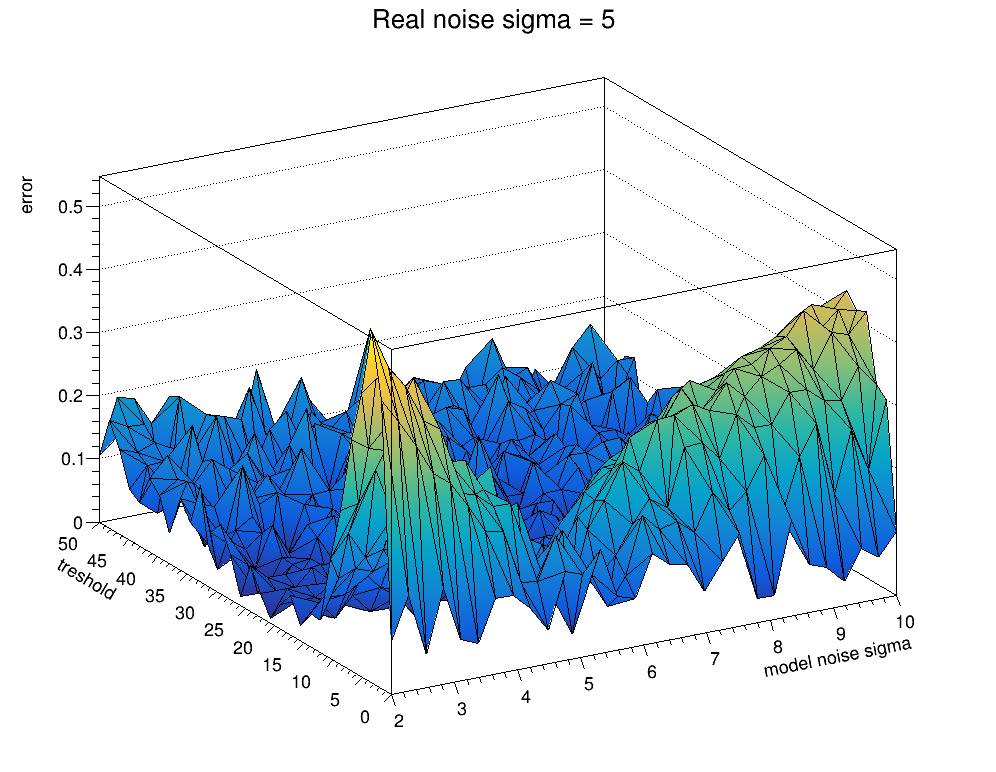

In [7]:
# Assume everything is known exactly except for noise_sigma
noise_sigma_uncertain_plot = ROOT.TGraph2D()
point_index = 0

real_signal = ROOT.TF1("Signal", "TMath::Landau(x, %f, %f)" % (real_signal_mu, real_signal_sigma), -100, 500)
real_signal.SetNpx(10000)
for model_noise_sigma in model_noise_sigmas:
    model_noise = ROOT.TF1("ElecNoiseBg", "TMath::Gaus(x, %f, %f)" % (real_noise_mu, model_noise_sigma), -100, 500)
    model_noise.SetNpx(10000)
    for treshold_value in treshold_values:
        expected_signal_above = 1 - real_signal.Integral(-100, treshold_value)/real_signal.Integral(-100, 500)
        expected_noise_above = 1 - model_noise.Integral(-100, treshold_value)/model_noise.Integral(-100, 500)
        
        noise_above_count = 0
        signal_above_count = 0
        
        for i in range(real_signal_count):
            signal = prng.Landau(real_signal_mu, real_signal_sigma)
            if signal > treshold_value:
                signal_above_count += 1

        for i in range(real_noise_count):
            noise = prng.Gaus(real_noise_mu, real_noise_sigma)
            if noise > treshold_value:
                noise_above_count += 1
                
        total_above_count = noise_above_count + signal_above_count
        
        total_count = total_above_count/(real_event_ratio*expected_signal_above + (1-real_event_ratio)*expected_noise_above)
        computed_signal_count = total_count*real_event_ratio
        
        deviation = np.sqrt(abs(1 - computed_signal_count/real_signal_count))
        
        noise_sigma_uncertain_plot.SetPoint(point_index, model_noise_sigma, treshold_value, deviation)
        point_index += 1

# Draw the plot
noise_sigma_uncertain_plot.Draw("TRI1")
set_title(noise_sigma_uncertain_plot, "Real noise sigma = "+ str(real_noise_sigma), "model noise sigma", "treshold", "error")
canvas.Draw()

Looking at the above plot we see that unless model noise sigma is the correct value, the treshold must be high to keep the error low. This is in exact opposite of the case when the signal mu was unknown. The error also drops when the treshold is close to zero, this is because then, the distribution does not matter anymore as all noise will be registered. 

## Event Ratio unknown

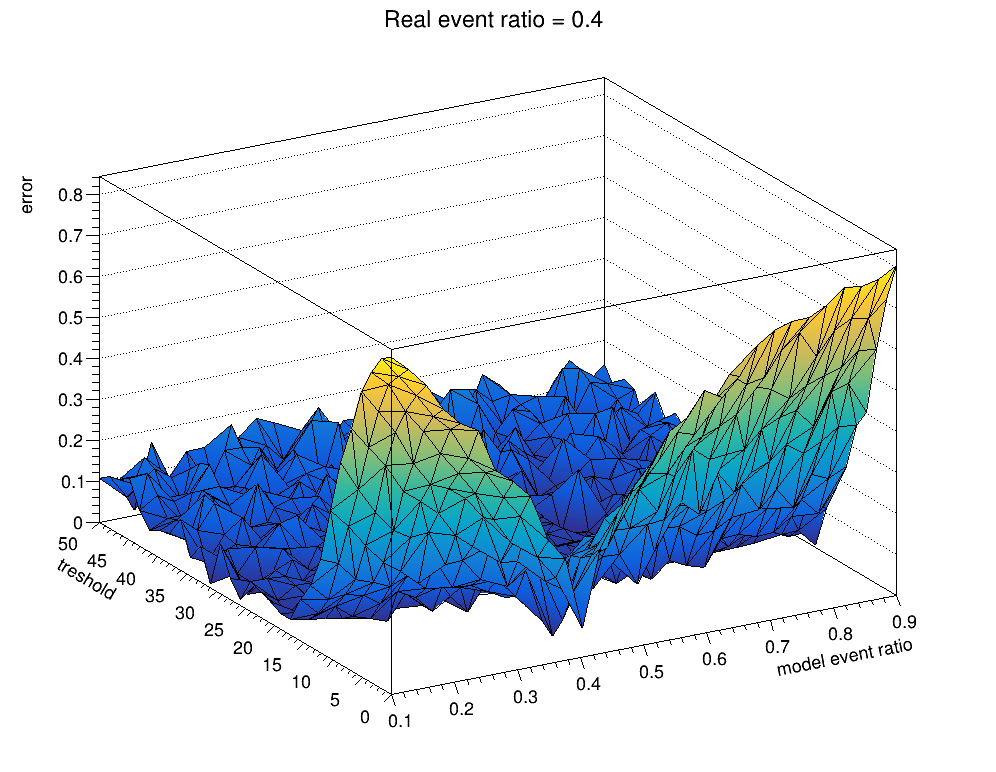

In [8]:
# Assume everything is known exactly except for event_ratio
event_ratio_uncertain_plot = ROOT.TGraph2D()
point_index = 0

real_signal = ROOT.TF1("Signal", "TMath::Landau(x, %f, %f)" % (real_signal_mu, real_signal_sigma), -100, 500)
real_signal.SetNpx(10000)
real_noise = ROOT.TF1("ElecNoiseBg", "TMath::Gaus(x, %f, %f)" % (real_noise_mu, real_noise_sigma), -100, 500)
real_noise.SetNpx(10000)

for treshold_value in treshold_values:
    expected_signal_above = 1 - real_signal.Integral(-100, treshold_value)/real_signal.Integral(-100, 500)
    expected_noise_above = 1 - real_noise.Integral(-100, treshold_value)/real_noise.Integral(-100, 500)
    for model_event_ratio in model_event_ratios:       
        noise_above_count = 0
        signal_above_count = 0
        
        for i in range(real_signal_count):
            signal = prng.Landau(real_signal_mu, real_signal_sigma)
            if signal > treshold_value:
                signal_above_count += 1

        for i in range(real_noise_count):
            noise = prng.Gaus(real_noise_mu, real_noise_sigma)
            if noise > treshold_value:
                noise_above_count += 1
                
        total_above_count = noise_above_count + signal_above_count
        
        total_count = total_above_count/(model_event_ratio*expected_signal_above + (1-model_event_ratio)*expected_noise_above)
        computed_signal_count = total_count*model_event_ratio
        
        deviation = np.sqrt(abs(1 - computed_signal_count/real_signal_count))
        
        event_ratio_uncertain_plot.SetPoint(point_index, model_event_ratio, treshold_value, deviation)
        point_index += 1

# Draw the plot
event_ratio_uncertain_plot.Draw("TRI1")
set_title(event_ratio_uncertain_plot, "Real event ratio = "+ str(real_event_ratio), "model event ratio", "treshold", "error")
canvas.Draw()

In the above plot it is clear to see that unless the event ratio is correctly known, it is best to keep a high treshold to keep the noise out.

## Discussion

In all these simulations we assume that we know all paramaters except for one. This is an unlikely scenario, but sadly we can only plot two paramaters against each other at the same time. Doing it this way makes plots that often has larger flat areas with low error. One way to maybe get more interesting plots is to assume a non-zero static error in the paramaters that are not being varied.

Another thing that can be done is to select a fix treshold and study how sensitive that treshold is to errors in two other paramaters.

If we look back at the plots we have generated so far, do they seem reasonable? I think they do.

## Set Fix errors

In [9]:
# Set the fixed errors
signal_sigma_offset = 5
noise_mu_offset = 0
noise_sigma_offset = 2

# A value of 0.3 means that the model assumes there is 30% less signal than it really is
# A value of -0.3 means that the model assumes there is 30% less noise than it really is
event_ratio_relative_error = 0.1

# Compute the model paramaters
model_signal_sigma = real_signal_sigma + signal_sigma_offset
model_noise_mu = real_noise_mu + noise_mu_offset
model_noise_sigma = real_noise_sigma + noise_sigma_offset
model_event_ratio = real_event_ratio
if event_ratio_relative_error > 0:
    model_event_ratio = real_event_ratio - real_event_ratio * event_ratio_relative_error
elif event_ratio_relative_error < 0:
    model_event_ratio = real_event_ratio - (1 - real_event_ratio) * event_ratio_relative_error

## Multiple assumed errors with varying signal mu and varying treshold

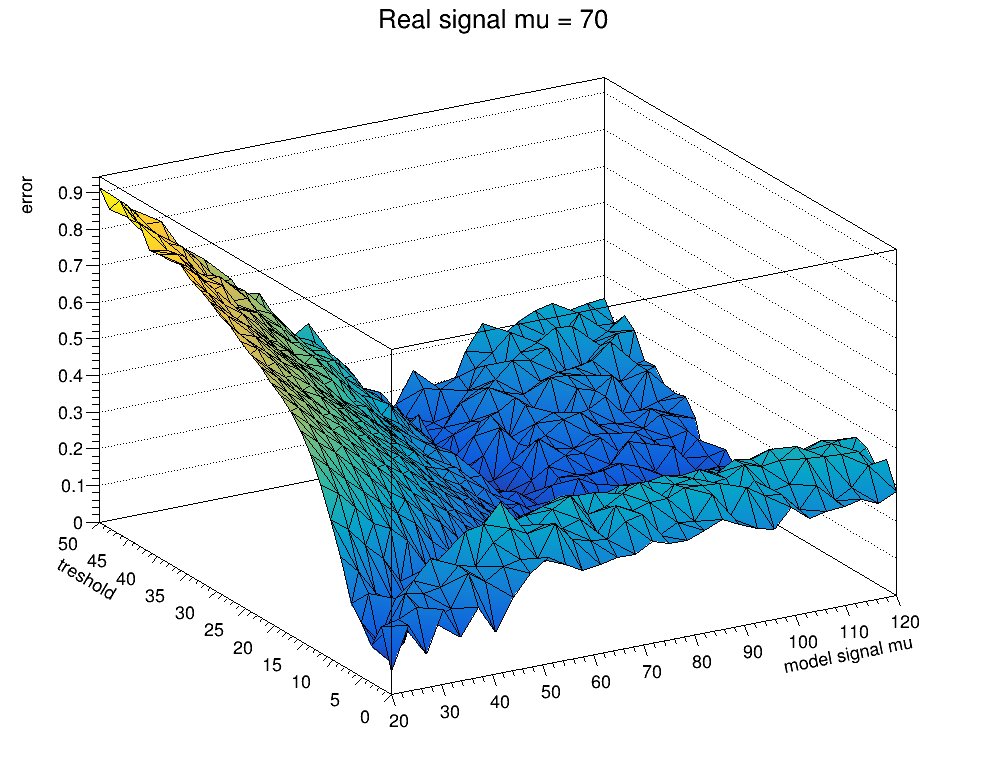

In [10]:
multiple_uncertain_plot = ROOT.TGraph2D()
point_index = 0

real_noise = ROOT.TF1("ElecNoiseBg", "TMath::Gaus(x, %f, %f)" % (model_noise_mu, model_noise_sigma), -100, 500)
real_noise.SetNpx(10000)
for model_signal_mu in model_signal_mus:
    model_signal = ROOT.TF1("Signal", "TMath::Landau(x, %f, %f)" % (model_signal_mu, model_signal_sigma), -100, 500)
    model_signal.SetNpx(10000)
    for treshold_value in treshold_values:
        expected_signal_above = 1 - model_signal.Integral(-100, treshold_value)/model_signal.Integral(-100, 500)
        expected_noise_above = 1 - real_noise.Integral(-100, treshold_value)/real_noise.Integral(-100, 500)
        
        noise_above_count = 0
        signal_above_count = 0
        
        for i in range(real_signal_count):
            signal = prng.Landau(real_signal_mu, real_signal_sigma)
            if signal > treshold_value:
                signal_above_count += 1

        for i in range(real_noise_count):
            noise = prng.Gaus(real_noise_mu, real_noise_sigma)
            if noise > treshold_value:
                noise_above_count += 1
                
        total_above_count = noise_above_count + signal_above_count
        
        total_count = total_above_count/(model_event_ratio*expected_signal_above + (1-model_event_ratio)*expected_noise_above)
        computed_signal_count = total_count*model_event_ratio
        
        deviation = np.sqrt(abs(1 - computed_signal_count/real_signal_count))
        
        multiple_uncertain_plot.SetPoint(point_index, model_signal_mu, treshold_value, deviation)
        point_index += 1

# Draw the plot
multiple_uncertain_plot.Draw("TRI1")
set_title(multiple_uncertain_plot, "Real signal mu = "+ str(real_signal_mu), "model signal mu", "treshold", "error")
canvas.Draw()

When we have added reasonable static errors to the non-varying paramaters, the plot becomes more giving. In the plot above, we can clearly see that the lowest error is not acheived for any extreme value of any paramater as often was the case for the isolated error plots. A rough esitmation of a good treshold value based on the above plot is about 20.

## Fix Treshold

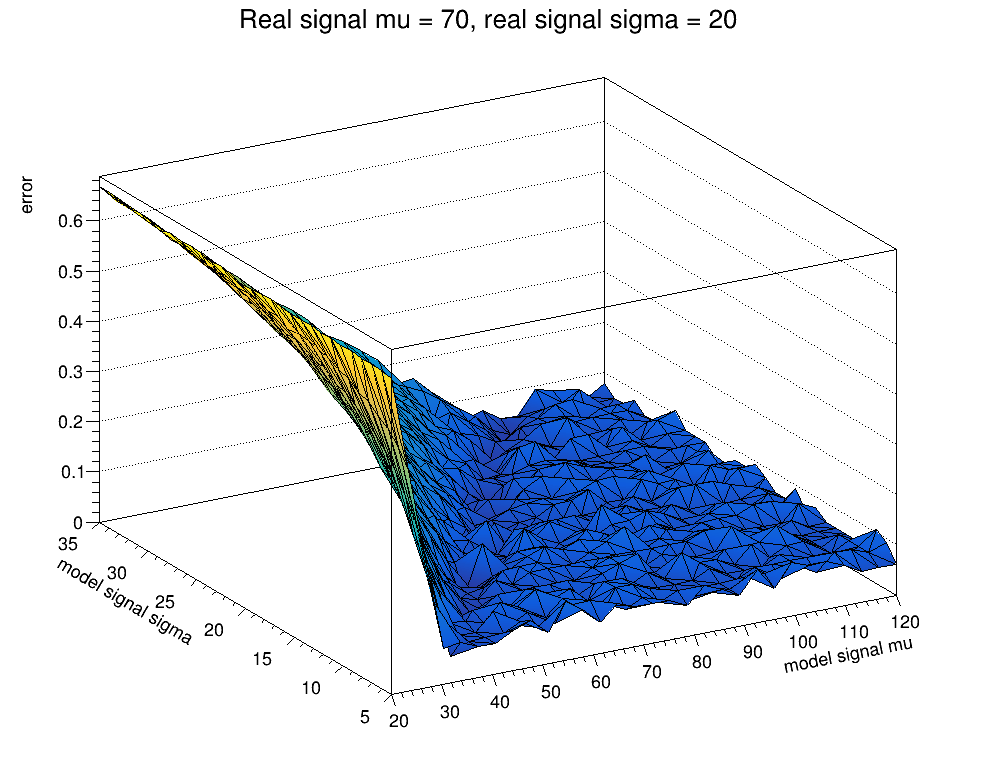

In [11]:
treshold_value = 20

fix_treshold_plot = ROOT.TGraph2D()
point_index = 0

real_noise = ROOT.TF1("ElecNoiseBg", "TMath::Gaus(x, %f, %f)" % (model_noise_mu, model_noise_sigma), -100, 500)
real_noise.SetNpx(10000)
for model_signal_mu in model_signal_mus:
    for model_signal_sigma in model_signal_sigmas:
        model_signal = ROOT.TF1("Signal", "TMath::Landau(x, %f, %f)" % (model_signal_mu, model_signal_sigma), -100, 500)
        model_signal.SetNpx(10000)
        expected_signal_above = 1 - model_signal.Integral(-100, treshold_value)/model_signal.Integral(-100, 500)
        expected_noise_above = 1 - real_noise.Integral(-100, treshold_value)/real_noise.Integral(-100, 500)
        
        noise_above_count = 0
        signal_above_count = 0
        
        for i in range(real_signal_count):
            signal = prng.Landau(real_signal_mu, real_signal_sigma)
            if signal > treshold_value:
                signal_above_count += 1

        for i in range(real_noise_count):
            noise = prng.Gaus(real_noise_mu, real_noise_sigma)
            if noise > treshold_value:
                noise_above_count += 1
                
        total_above_count = noise_above_count + signal_above_count
        
        total_count = total_above_count/(model_event_ratio*expected_signal_above + (1-model_event_ratio)*expected_noise_above)
        computed_signal_count = total_count*model_event_ratio
        
        deviation = np.sqrt(abs(1 - computed_signal_count/real_signal_count))
        
        fix_treshold_plot.SetPoint(point_index, model_signal_mu, model_signal_sigma, deviation)
        point_index += 1

# Draw the plot
fix_treshold_plot.Draw("TRI1")
set_title(fix_treshold_plot, "Real signal mu = "+ str(real_signal_mu) + ", real signal sigma = " + str(real_signal_sigma), "model signal mu", "model signal sigma", "error")
canvas.Draw()

There seems to be a large plat area where the error is low. This is most likely due to the fact that for the chosen treshold and real model of signal, close to no noise is counted in which in and close to all signals are countet which makes the signal distribution unimportant as long as it is such that more or less all signal is above the treshold. We can verify this hypothesis with another plot.

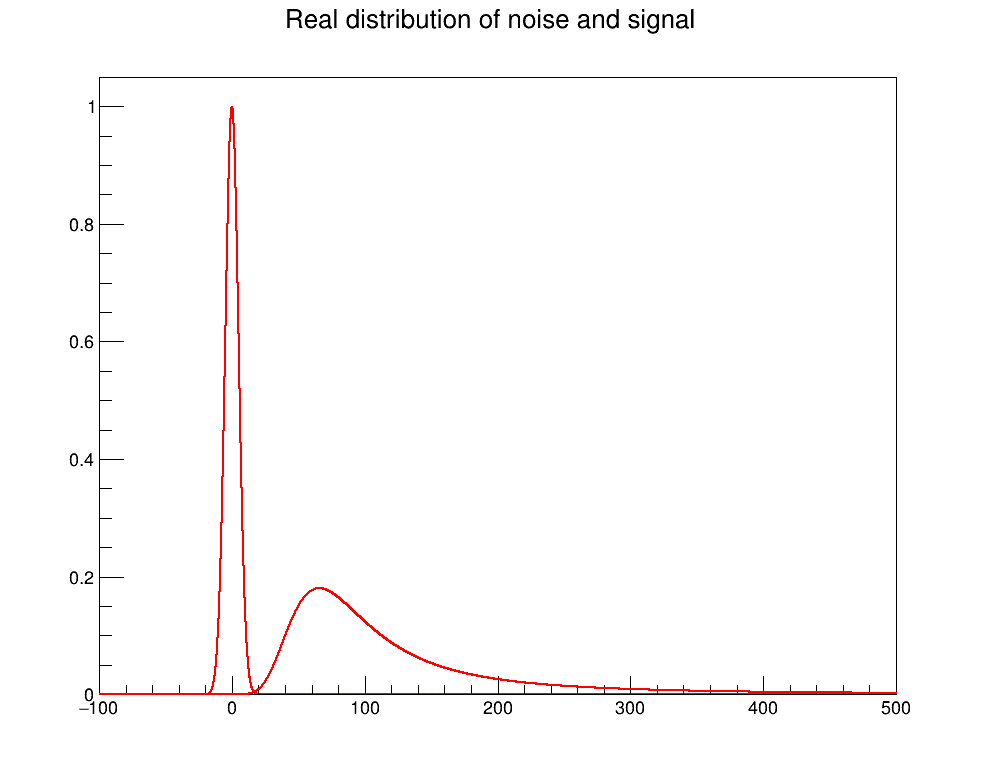

In [12]:
real_noise = ROOT.TF1("ElecNoiseBg", "TMath::Gaus(x, %f, %f)" % (real_noise_mu, real_noise_sigma), -100, 500)
real_noise.SetNpx(10000)
real_signal = ROOT.TF1("Signal", "TMath::Landau(x, %f, %f)" % (real_signal_mu, real_signal_sigma), -100, 500)
real_signal.SetNpx(10000)
real_noise.SetTitle("Real distribution of noise and signal")

real_noise.Draw()
real_noise.GetXaxis().SetLabelSize(0.025)
real_noise.GetYaxis().SetLabelSize(0.025)
real_signal.Draw("SAME")
canvas.Draw()

The hypothesis seems correct, now I got exited about what happens when the distributions overlap more.

## Conclusion

When the distributions do not intersect too much, setting the treshold is easy. Put it in the center of the interval formed between the two distributions where they are almost zero. By adjusting the real signal mu to 40 from 70, the plots change, especially the one with multiple fixed errors.